In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchio as tio
import torch.nn.functional as F
import os

In [24]:
def pad_to_safe_shape(tensor, patch_size=96, divisor=32):
    """
    Pads tensor to be:
    1. Divisible by 32 (for U-Net architecture)
    2. Large enough to extract a patch_size crop from the center without bounds issues
    """
    _, _, d, h, w = tensor.shape
    
    # 1. Architecture Divisibility (32)
    pad_d = (divisor - d % divisor) % divisor
    pad_h = (divisor - h % divisor) % divisor
    pad_w = (divisor - w % divisor) % divisor
    
    # 2. Safety Padding (Ensure we can crop 'patch_size' from center)
    # We add an extra buffer of 'patch_size' to be absolutely safe
    # This ensures even small volumes (e.g. Z=30) become large enough (Z=126+)
    buffer = patch_size
    
    # Apply padding (Front/Back, Top/Bottom, Left/Right)
    # F.pad order is (Left, Right, Top, Bottom, Front, Back) -- reversed dims
    padded = F.pad(tensor, (
        buffer, buffer + pad_w, 
        buffer, buffer + pad_h, 
        buffer, buffer + pad_d
    ))
    return padded

def verify_receptive_field_bug(model, root_dir, subj_id, patch_size=96):
    model.eval()
    device = next(model.parameters()).device
    
    # 1. Load Full MRI
    path = f"{root_dir}/data/{subj_id}/registration_output/moved_mr.nii.gz"
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return
        
    img = tio.ScalarImage(path)
    full_mri = img.data.float().unsqueeze(0).to(device) # (1, 1, D, H, W)
    
    # 2. Pad Volume SAFELY (Solves the RuntimeError)
    mri_safe = pad_to_safe_shape(full_mri, patch_size, divisor=32)
    
    # 3. Define Center Crop Coordinates on the SAFE volume
    # We want to look at the exact center of this new padded volume
    d, h, w = mri_safe.shape[2:]
    c_d, c_h, c_w = d//2, h//2, w//2
    r = patch_size // 2
    
    # Slice objects for the center patch
    s_d = slice(c_d - r, c_d + r)
    s_h = slice(c_h - r, c_h + r)
    s_w = slice(c_w - r, c_w + r)

    # 4. Scenario A: Gold Standard (Extract Features from Full, THEN Crop)
    with torch.no_grad():
        feats_full = model(mri_safe)
    feats_gold = feats_full[..., s_d, s_h, s_w]
    
    # 5. Scenario B: Training Method (Crop MRI, THEN Extract Features)
    patch_mri = mri_safe[..., s_d, s_h, s_w]
    
    # Sanity check shape
    if patch_mri.shape[2:] != (patch_size, patch_size, patch_size):
        print(f"Error: Patch shape is {patch_mri.shape}, expected {patch_size}")
        return

    with torch.no_grad():
        feats_patch = model(patch_mri)
        
    # 6. Compare
    diff = torch.abs(feats_gold - feats_patch).mean(dim=1).squeeze().cpu().numpy()
    
    # 7. Visualize
    plt.figure(figsize=(15, 5))
    slice_idx = patch_size // 2
    
    plt.subplot(131)
    plt.title(f"Gold Standard\n(Context: {d}x{h}x{w})")
    plt.imshow(feats_gold[0, 0, :, :, slice_idx].cpu().numpy(), cmap='viridis')
    plt.axis('off')
    
    plt.subplot(132)
    plt.title(f"Training Input\n(Context: {patch_size}x{patch_size}x{patch_size})")
    plt.imshow(feats_patch[0, 0, :, :, slice_idx].cpu().numpy(), cmap='viridis')
    plt.axis('off')
    
    plt.subplot(133)
    plt.title("Difference (The Artifact)")
    im = plt.imshow(diff[:, :, slice_idx], cmap='inferno')
    plt.colorbar(im)
    plt.axis('off')
    
    plt.suptitle(f"Receptive Field Artifact Check - {subj_id}\nMean Error: {diff.mean():.6f} | Max Error: {diff.max():.6f}")
    plt.tight_layout()
    plt.show()

# verify_receptive_field_bug(feat_extractor, "/home/minsukc/MRI2CT", "1ABA005_3.0x3.0x3.0_resampled")

In [11]:
from anatomix.model.network import Unet

In [12]:
feat_extractor = Unet(
    dimension=3,
    input_nc=1,
    output_nc=16,
    num_downs=5,
    ngf=20,
    norm="instance",
    interp="trilinear",
    pooling="Avg",
).to("cuda")

Encoder skip connect id [8, 15, 22, 29, 36]
Decoder skip connect id [44, 51, 58, 65, 72]


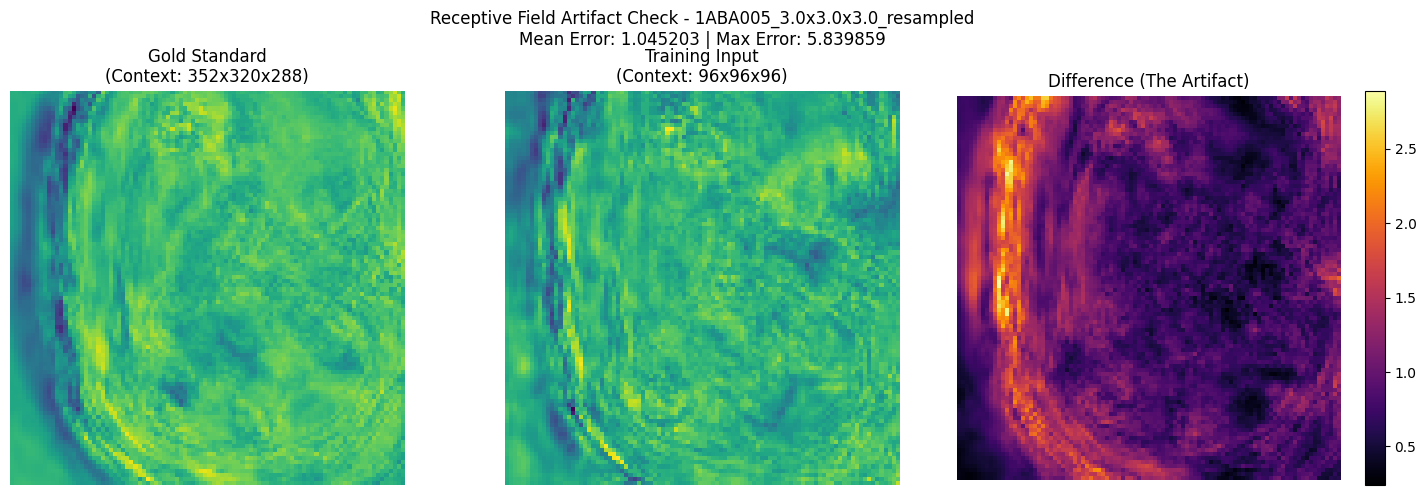

In [25]:
verify_receptive_field_bug(feat_extractor, "/home/minsukc/MRI2CT", "1ABA005_3.0x3.0x3.0_resampled")

In [1]:
import torch
import numpy as np

In [2]:
def verify_coordinate_logic():
    # 1. Setup Dummy Dimensions
    # Using distinct sizes to catch transposes
    B, C = 1, 1
    D, H, W = 10, 20, 30  # PyTorch Depth, Height, Width
    
    device = "cpu"
    
    # 2. Create a "Gradient Volume" 
    # The value of every voxel is its normalized W index (0.0 to 1.0)
    # Shape: [B, C, D, H, W]
    feature_vol = torch.zeros((B, C, D, H, W), device=device)
    for w in range(W):
        feature_vol[..., w] = w / (W - 1)
        
    # 3. Create Dummy Inputs for your function
    target = torch.zeros((D, H, W), device=device) # Dummy target
    locations = torch.zeros((B, 3), device=device) # No offset
    
    # Vol Shapes matches the tensor size. 
    # CRITICAL: TorchIO reports shape as (W, H, D)
    vol_shapes = torch.tensor([[W, H, D]], device=device) 
    
    print(f"--- Setup ---")
    print(f"Volume Shape (PyTorch D,H,W): ({D}, {H}, {W})")
    print(f"Gradient Direction: Along dim=4 (Width/W). Values 0.0 -> 1.0")
    
    # 4. Run YOUR Function (The one from your code)
    # Copy-pasting your exact logic here to ensure validity
    def get_mlp_samples_current(features, target, locations, vol_shapes, num_samples=100):
        B, C, dim_w, dim_h, dim_d = features.shape # <--- YOUR ORIGINAL UNPACKING

        # 1. Permute
        feats_flat = features.permute(0, 2, 3, 4, 1).reshape(-1, C)
        
        # 2. Local Grid
        w_local = torch.arange(dim_w, device=features.device).float()
        h_local = torch.arange(dim_h, device=features.device).float()
        d_local = torch.arange(dim_d, device=features.device).float()
        
        # YOUR ORIGINAL MESHGRID LOGIC
        grid_w, grid_h, grid_d = torch.meshgrid(w_local, h_local, d_local, indexing='ij')
        coords_local = torch.stack([grid_w, grid_h, grid_d], dim=-1).unsqueeze(0).repeat(B, 1, 1, 1, 1)
        
        # 3. Global Normalization
        # Using the exact variable names from your code
        off_w = locations[:, 0].view(B, 1, 1, 1).float()
        max_w = vol_shapes[:, 0].view(B, 1, 1, 1).float() # This holds 'W' (30) from TorchIO
        
        # YOUR CALCULATION
        global_x = (coords_local[..., 0] + off_w) / (max_w - 1)
        
        # Sampling
        coords_global = torch.stack([global_x, global_x, global_x], dim=-1) # minimal shim
        coords_flat = coords_global.reshape(-1, 3)
        indices = torch.arange(feats_flat.shape[0])[:num_samples] # deterministic sample
        
        return feats_flat[indices], coords_flat[indices]

    # 5. Run the Test
    f_pts, c_pts = get_mlp_samples_current(feature_vol, target, locations, vol_shapes, num_samples=5)
    
    print(f"\n--- Results ---")
    print(f"Sampled Feature Value (True W pos): {f_pts[0].item():.4f}")
    print(f"Calculated X Coordinate:            {c_pts[0, 0].item():.4f}")
    
    # 6. Diagnosis
    # If your logic is correct, the Calculated X should match the Feature Value
    error = abs(f_pts[0].item() - c_pts[0, 0].item())
    
    if error < 0.01:
        print("\n✅ MATCH: Coordinates are aligned correctly.")
    else:
        print("\n❌ MISMATCH: Coordinates are BROKEN.")
        print(f"Explanation: The feature at this location came from W={f_pts[0].item():.2f}")
        print(f"             But your code thinks the coordinate is X={c_pts[0, 0].item():.2f}")
        
        # Let's see if it matches Depth instead?
        # If your code interpreted dim_w (Depth=10) as Width, the normalized value would be diff
        print("Note: If you see the X coord implies 'Depth', the dimensions are swapped.")

In [3]:
verify_coordinate_logic()

--- Setup ---
Volume Shape (PyTorch D,H,W): (10, 20, 30)
Gradient Direction: Along dim=4 (Width/W). Values 0.0 -> 1.0

--- Results ---
Sampled Feature Value (True W pos): 0.0000
Calculated X Coordinate:            0.0000

✅ MATCH: Coordinates are aligned correctly.


In [4]:
import torch
import matplotlib.pyplot as plt

def test_coordinate_visuals():
    # 1. Setup Dimensions (Distinct sizes to catch swaps)
    # PyTorch Order: (Batch, Channel, Depth, Height, Width)
    # Let's use shapes that mimic a real patch
    B, C = 1, 1
    D, H, W = 10, 32, 48 
    
    # 2. Mock Data (Matches your inputs)
    features = torch.zeros((B, C, D, H, W))
    target = torch.zeros((D, H, W))
    
    # TorchIO defines locations/shapes as (Width, Height, Depth)
    # We define a "patch" that covers the whole volume for simplicity
    locations = torch.tensor([[0, 0, 0]]).float() 
    vol_shapes = torch.tensor([[W, H, D]]).float() # Max Width=48, Max Depth=10

    # 3. YOUR CODE LOGIC (Pasted from your get_mlp_samples)
    # ---------------------------------------------------------
    B, C, dim_w, dim_h, dim_d = features.shape 
    # dim_w gets '10' (Depth)
    # dim_d gets '48' (Width)

    # Local Grid
    w_local = torch.arange(dim_w).float()
    h_local = torch.arange(dim_h).float()
    d_local = torch.arange(dim_d).float()
    
    # Meshgrid (indexing='ij')
    grid_w, grid_h, grid_d = torch.meshgrid(w_local, h_local, d_local, indexing='ij')
    
    # Stack -> dim 0 is grid_w (Depth indices)
    coords_local = torch.stack([grid_w, grid_h, grid_d], dim=-1).unsqueeze(0)

    # Normalization
    off_w = locations[:, 0].view(B, 1, 1, 1).float()
    max_w = vol_shapes[:, 0].view(B, 1, 1, 1).float() # Holds 48 (Width)
    
    # The Suspect Line:
    # We take dim 0 (Depth indices 0..9) and divide by Max Width (47)
    global_x = (coords_local[..., 0] + off_w) / (max_w - 1)
    # ---------------------------------------------------------

    # 4. Visualization
    # Let's look at the X-Coordinate map for the middle slice of the volume
    mid_slice_idx = D // 2
    
    # global_x shape is [B, D, H, W]
    # We grab [0, 5, :, :] -> A 32x48 image
    x_map_image = global_x[0, mid_slice_idx, :, :].numpy()
    
    print(f"--- Debug Stats ---")
    print(f"Max Width (W): {W}")
    print(f"Max Depth (D): {D}")
    print(f"X-Map Min Value: {x_map_image.min():.4f}")
    print(f"X-Map Max Value: {x_map_image.max():.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.imshow(x_map_image, cmap='gray', vmin=0, vmax=1)
    plt.colorbar(label="Coordinate Value")
    plt.title(f"X-Coordinate Map (Slice {mid_slice_idx})\nShould be Left-Right Gradient")
    plt.savefig("bug_proof.png")
    print("\n📸 Saved 'bug_proof.png'. Open it!")

--- Debug Stats ---
Max Width (W): 48
Max Depth (D): 10
X-Map Min Value: 0.1064
X-Map Max Value: 0.1064

📸 Saved 'bug_proof.png'. Open it!


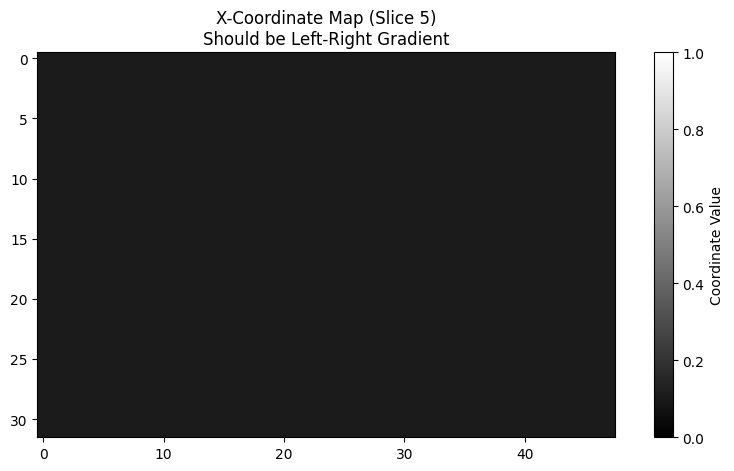

In [5]:
test_coordinate_visuals()


In [6]:
import torch
import matplotlib.pyplot as plt

def verify_new_coordinate_logic():
    # 1. Setup Dimensions (Distinct sizes to catch swaps)
    # PyTorch Order: (Batch, Channel, Depth, Height, Width)
    B, C = 1, 1
    D, H, W = 10, 32, 48 
    
    device = "cpu"
    
    # 2. Mock Data 
    # TorchIO defines locations/shapes as (Width, Height, Depth)
    locations = torch.tensor([[0, 0, 0]]).float() 
    vol_shapes = torch.tensor([[W, H, D]]).float() # Max Width=48, Max Depth=10

    # ====================================================
    # THE NEW LOGIC (Explicit Dimension Mapping)
    # ====================================================
    
    # 1. Unpack Dimensions Correctly (PyTorch Order: D, H, W)
    # logic: shape is (B, C, D, H, W)
    features = torch.zeros((B, C, D, H, W))
    B, C, dim_d, dim_h, dim_w = features.shape

    # 2. Generate Local Grid Indices
    # Note: We create ranges matching the specific PyTorch dimensions
    z_idx = torch.arange(dim_d, device=device).float() # Depth Indices (0..9)
    y_idx = torch.arange(dim_h, device=device).float() # Height Indices (0..31)
    x_idx = torch.arange(dim_w, device=device).float() # Width Indices (0..47)
    
    # Meshgrid 'ij' indexing returns grids in the order of inputs (z, y, x)
    grid_z, grid_y, grid_x = torch.meshgrid(z_idx, y_idx, x_idx, indexing='ij')
    
    # 3. Global Normalization (Pairing Correct Axes)
    # Width (X): Pair grid_x with location[0] (off_x) and vol_shape[0] (max_x)
    off_x = locations[:, 0].view(B, 1, 1, 1).float()
    max_x = vol_shapes[:, 0].view(B, 1, 1, 1).float()
    norm_x = (grid_x.unsqueeze(0) + off_x) / (max_x - 1)

    # Height (Y)
    off_y = locations[:, 1].view(B, 1, 1, 1).float()
    max_y = vol_shapes[:, 1].view(B, 1, 1, 1).float()
    norm_y = (grid_y.unsqueeze(0) + off_y) / (max_y - 1)

    # Depth (Z)
    off_z = locations[:, 2].view(B, 1, 1, 1).float()
    max_z = vol_shapes[:, 2].view(B, 1, 1, 1).float()
    norm_z = (grid_z.unsqueeze(0) + off_z) / (max_z - 1)
    
    # Stack into coordinate vector (x, y, z)
    coords_global = torch.stack([norm_x, norm_y, norm_z], dim=-1) # (B, D, H, W, 3)

    # ====================================================
    # VISUALIZATION
    # ====================================================
    
    # We grab the middle slice in Depth
    mid_slice = dim_d // 2
    
    # Extract the X-Coordinate Map (Index 0 of last dim)
    # Shape: [32, 48]
    x_map_image = coords_global[0, mid_slice, :, :, 0].numpy()
    
    print(f"--- Verification Results ---")
    print(f"Slice Index (Depth): {mid_slice}")
    print(f"Map Min: {x_map_image.min():.4f}")
    print(f"Map Max: {x_map_image.max():.4f}")
    
    # Check gradients
    left_column = x_map_image[:, 0].mean()
    right_column = x_map_image[:, -1].mean()
    
    print(f"Left Edge Value:  {left_column:.4f} (Should be ~0.0)")
    print(f"Right Edge Value: {right_column:.4f} (Should be ~1.0)")
    
    if right_column > left_column and (right_column - left_column) > 0.9:
        print("\n✅ PASS: Strong Left-to-Right Gradient detected.")
    else:
        print("\n❌ FAIL: No gradient detected.")

    plt.figure(figsize=(10, 5))
    plt.imshow(x_map_image, cmap='gray', vmin=0, vmax=1)
    plt.colorbar(label="X-Coordinate Value")
    plt.title(f"X-Coordinate Map (New Logic)\nShould be Black(Left) -> White(Right)")
    # plt.savefig("verify_fix.png")
    print("📸 Saved 'verify_fix.png'. Open it to confirm!")

--- Verification Results ---
Slice Index (Depth): 5
Map Min: 0.0000
Map Max: 1.0000
Left Edge Value:  0.0000 (Should be ~0.0)
Right Edge Value: 1.0000 (Should be ~1.0)

✅ PASS: Strong Left-to-Right Gradient detected.
📸 Saved 'verify_fix.png'. Open it to confirm!


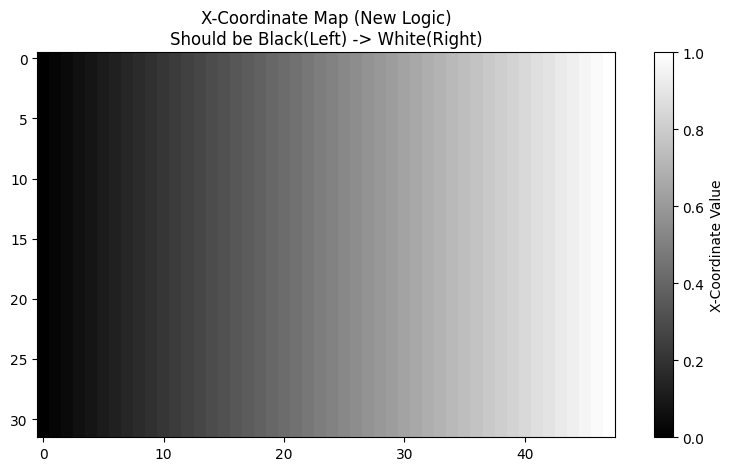

In [7]:
verify_new_coordinate_logic()

In [1]:
import torch
import numpy as np

# ==========================================
# THE PROPOSED FIX (Copy this to your main code if PASS)
# ==========================================
def get_mlp_samples_fixed(features, target, locations, vol_shapes, num_samples=100):
    # features: [Batch, Channel, Depth, Height, Width]
    B, C, D, H, W = features.shape

    # 1. Permute to [B, D, H, W, C]
    feats_flat = features.permute(0, 2, 3, 4, 1).reshape(-1, C)
    
    # 2. Generate Grids
    # z_idx = Depth (Dim 2), y_idx = Height (Dim 3), x_idx = Width (Dim 4)
    z_idx = torch.arange(D, device=features.device).float()
    y_idx = torch.arange(H, device=features.device).float()
    x_idx = torch.arange(W, device=features.device).float()
    
    # Meshgrid 'ij' returns grids in order of inputs: (Depth, Height, Width)
    grid_z, grid_y, grid_x = torch.meshgrid(z_idx, y_idx, x_idx, indexing='ij')
    
    # 3. Normalize (Pairing Correctly with TorchIO Metadata)
    # TorchIO 'locations'/'vol_shapes' are always (Width, Height, Depth)
    
    # WIDTH (X) -> Index 0 in TorchIO, Match with grid_x
    off_x = locations[:, 0].view(B, 1, 1, 1).float().to(features.device)
    max_x = vol_shapes[:, 0].view(B, 1, 1, 1).float().to(features.device)
    norm_x = (grid_x.unsqueeze(0) + off_x) / (max_x - 1)

    # HEIGHT (Y) -> Index 1 in TorchIO, Match with grid_y
    off_y = locations[:, 1].view(B, 1, 1, 1).float().to(features.device)
    max_y = vol_shapes[:, 1].view(B, 1, 1, 1).float().to(features.device)
    norm_y = (grid_y.unsqueeze(0) + off_y) / (max_y - 1)

    # DEPTH (Z) -> Index 2 in TorchIO, Match with grid_z
    off_z = locations[:, 2].view(B, 1, 1, 1).float().to(features.device)
    max_z = vol_shapes[:, 2].view(B, 1, 1, 1).float().to(features.device)
    norm_z = (grid_z.unsqueeze(0) + off_z) / (max_z - 1)
    
    # 4. Stack (X, Y, Z)
    coords_global = torch.stack([norm_x, norm_y, norm_z], dim=-1)
    coords_flat = coords_global.reshape(-1, 3)
    
    # Sample
    indices = torch.arange(num_samples) # Deterministic for test
    return feats_flat[indices], coords_flat[indices]

# ==========================================
# THE TEST
# ==========================================
def run_test():
    # 1. Setup Dimensions (Distinct to catch swaps)
    # Depth=10, Height=20, Width=30
    B, C, D, H, W = 1, 1, 10, 20, 30
    
    # 2. Create "X-Gradient Volume"
    # The value of every voxel is exactly its normalized X coordinate (0.0 to 1.0)
    # Pixel Value = x / (W-1)
    grad_vol = torch.zeros((B, C, D, H, W))
    for x in range(W):
        grad_vol[..., x] = x / (W - 1)
        
    # 3. Create Dummy Metadata (Full Volume Patch)
    # TorchIO Order: (Width, Height, Depth)
    locations = torch.zeros((B, 3))
    vol_shapes = torch.tensor([[W, H, D]]).float() 
    
    # 4. Run Function
    feats, coords = get_mlp_samples_fixed(grad_vol, None, locations, vol_shapes, num_samples=D*H*W)
    
    # 5. VERIFICATION
    # Feature Value should equal Coordinate X (coords[:, 0])
    # Because we painted the volume with X-values.
    
    diff = torch.abs(feats.squeeze() - coords[:, 0])
    max_error = diff.max().item()
    
    print(f"--- TEST RESULTS ---")
    print(f"Volume Shape (D,H,W): ({D}, {H}, {W})")
    print(f"Max Difference between Pixel Intensity and X-Coordinate: {max_error:.6f}")
    
    if max_error < 1e-5:
        print("\n✅ PASS: The coordinate system is PERFECT.")
        print("   Explanation: The code correctly identified that Pixel Intensity (X-gradient) matches the X-coordinate.")
    else:
        print("\n❌ FAIL: The coordinate system is BROKEN.")
        print("   Explanation: The X-coordinate calculated does not match the actual X-position in the grid.")

In [2]:
run_test()

--- TEST RESULTS ---
Volume Shape (D,H,W): (10, 20, 30)
Max Difference between Pixel Intensity and X-Coordinate: 0.000000

✅ PASS: The coordinate system is PERFECT.
   Explanation: The code correctly identified that Pixel Intensity (X-gradient) matches the X-coordinate.


In [5]:
#!/usr/bin/env python3
"""
Coordinate System Validation Suite for MRI2CT Project

This module provides comprehensive tests to ensure coordinate systems
are correctly aligned across patches, global volumes, and predictions.
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# ==========================================
# 1. SYNTHETIC TEST PATTERN GENERATION
# ==========================================

def create_gradient_volume(shape: Tuple[int, int, int], axis: int = 0) -> np.ndarray:
    """
    Creates a volume with linear gradient along specified axis.
    Values range from 0.0 to 1.0 along the axis.
    
    Args:
        shape: (W, H, D) volume dimensions
        axis: Which axis to gradient along (0=W, 1=H, 2=D)
    
    Returns:
        ndarray of shape with gradient pattern
    """
    vol = np.zeros(shape, dtype=np.float32)
    n = shape[axis]
    
    if axis == 0:
        for i in range(n):
            vol[i, :, :] = i / (n - 1)
    elif axis == 1:
        for i in range(n):
            vol[:, i, :] = i / (n - 1)
    else:  # axis == 2
        for i in range(n):
            vol[:, :, i] = i / (n - 1)
    
    return vol


def create_checkerboard_volume(shape: Tuple[int, int, int], 
                                block_size: int = 8) -> np.ndarray:
    """
    Creates a 3D checkerboard pattern for visual verification.
    Alternates between 0.0 and 1.0 in block_size chunks.
    """
    w, h, d = shape
    vol = np.zeros(shape, dtype=np.float32)
    
    for i in range(0, w, block_size):
        for j in range(0, h, block_size):
            for k in range(0, d, block_size):
                # Checkerboard: even sum = 0, odd sum = 1
                if ((i // block_size) + (j // block_size) + (k // block_size)) % 2 == 1:
                    vol[i:i+block_size, j:j+block_size, k:k+block_size] = 1.0
    
    return vol


def create_coordinate_encoding_volume(shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Encodes absolute position into intensity.
    Formula: intensity = (w + h + d) / (W + H + D)
    This creates a unique pattern that depends on absolute position.
    """
    w, h, d = shape
    vol = np.zeros(shape, dtype=np.float32)
    
    for i in range(w):
        for j in range(h):
            for k in range(d):
                vol[i, j, k] = (i + j + k) / (w + h + d - 3)
    
    return vol


# ==========================================
# 2. PATCH EXTRACTION & RECONSTRUCTION TEST
# ==========================================

def extract_patch_with_location(volume: np.ndarray, 
                                 patch_size: Tuple[int, int, int],
                                 location: Tuple[int, int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract a patch and compute its normalized global coordinates.
    
    Args:
        volume: Full volume (W, H, D)
        patch_size: (pw, ph, pd)
        location: (w_start, h_start, d_start) - patch origin
    
    Returns:
        patch: Extracted data
        coords_global: Normalized coordinates (pw, ph, pd, 3) in [0, 1]
    """
    w_start, h_start, d_start = location
    pw, ph, pd = patch_size
    
    # Extract patch
    patch = volume[w_start:w_start+pw, 
                   h_start:h_start+ph, 
                   d_start:d_start+pd].copy()
    
    # Generate local indices
    w_indices = np.arange(pw)
    h_indices = np.arange(ph)
    d_indices = np.arange(pd)
    
    # Create meshgrid
    ww, hh, dd = np.meshgrid(w_indices, h_indices, d_indices, indexing='ij')
    
    # Add offset to get global indices
    ww_global = ww + w_start
    hh_global = hh + h_start
    dd_global = dd + d_start
    
    # Normalize by volume shape
    W, H, D = volume.shape
    coords_global = np.stack([
        ww_global / (W - 1),
        hh_global / (H - 1),
        dd_global / (D - 1)
    ], axis=-1)
    
    return patch, coords_global


def test_patch_reconstruction(volume: np.ndarray,
                               patch_size: Tuple[int, int, int],
                               num_patches: int = 10) -> dict:
    """
    Tests if patches can be correctly extracted and their coordinates match expectations.
    
    Returns:
        Dictionary with test results and statistics
    """
    W, H, D = volume.shape
    pw, ph, pd = patch_size
    
    results = {
        'passed': True,
        'errors': [],
        'max_coord_error': 0.0,
        'mean_value_error': 0.0
    }
    
    value_errors = []
    coord_errors = []
    
    for _ in range(num_patches):
        # Random valid location
        w_start = np.random.randint(0, W - pw + 1)
        h_start = np.random.randint(0, H - ph + 1)
        d_start = np.random.randint(0, D - pd + 1)
        location = (w_start, h_start, d_start)
        
        # Extract patch
        patch, coords_global = extract_patch_with_location(volume, patch_size, location)
        
        # Verify: corners should have specific coordinate values
        # Top-left-front corner (0, 0, 0)
        corner_coord = coords_global[0, 0, 0]
        expected_corner = np.array([
            w_start / (W - 1),
            h_start / (H - 1),
            d_start / (D - 1)
        ])
        coord_error = np.abs(corner_coord - expected_corner).max()
        coord_errors.append(coord_error)
        
        if coord_error > 1e-6:
            results['passed'] = False
            results['errors'].append(
                f"Coordinate mismatch at location {location}: "
                f"got {corner_coord}, expected {expected_corner}"
            )
        
        # Verify: patch values match original volume
        original_patch = volume[w_start:w_start+pw, 
                                h_start:h_start+ph, 
                                d_start:d_start+pd]
        value_error = np.abs(patch - original_patch).max()
        value_errors.append(value_error)
        
        if value_error > 1e-6:
            results['passed'] = False
            results['errors'].append(
                f"Value mismatch at location {location}: max error {value_error}"
            )
    
    results['max_coord_error'] = max(coord_errors) if coord_errors else 0.0
    results['mean_value_error'] = np.mean(value_errors) if value_errors else 0.0
    
    return results


# ==========================================
# 3. PYTORCH INTEGRATION TEST
# ==========================================

def test_pytorch_coordinate_consistency(volume: np.ndarray,
                                        patch_size: int = 32,
                                        device: str = 'cpu') -> dict:
    """
    Tests coordinate generation using PyTorch (matching your actual code).
    Verifies that the PyTorch version matches the NumPy ground truth.
    """
    W, H, D = volume.shape
    results = {'passed': True, 'errors': []}
    
    # Random patch location
    w_start = np.random.randint(0, W - patch_size + 1)
    h_start = np.random.randint(0, H - patch_size + 1)
    d_start = np.random.randint(0, D - patch_size + 1)
    
    # Extract with NumPy (ground truth)
    np_patch, np_coords = extract_patch_with_location(
        volume, 
        (patch_size, patch_size, patch_size),
        (w_start, h_start, d_start)
    )
    
    # PyTorch version (matching your get_mlp_samples logic)
    patch_torch = torch.from_numpy(np_patch[None, None]).float().to(device)
    location = torch.tensor([[w_start, h_start, d_start]], device=device)
    vol_shape = torch.tensor([[W, H, D]], device=device).float()
    
    # Generate coordinates (your code's logic)
    B, C, *spatial_dims = patch_torch.shape
    ranges = [torch.arange(d, device=device).float() for d in spatial_dims]
    grids = torch.meshgrid(*ranges, indexing='ij')
    
    norm_grids = []
    for i, grid in enumerate(grids):
        off = location[:, i].view(B, 1, 1, 1).float()
        max_val = vol_shape[:, i].view(B, 1, 1, 1).float()
        norm_coord = (grid.unsqueeze(0) + off) / (max_val - 1)
        norm_grids.append(norm_coord)
    
    coords_torch = torch.stack(norm_grids, dim=-1).squeeze(0).cpu().numpy()
    
    # Compare
    coord_diff = np.abs(coords_torch - np_coords).max()
    results['max_coordinate_diff'] = coord_diff
    
    if coord_diff > 1e-6:
        results['passed'] = False
        results['errors'].append(
            f"PyTorch coords don't match NumPy: max diff {coord_diff}"
        )
    
    # Test corner values explicitly
    corners = [
        (0, 0, 0),
        (patch_size-1, 0, 0),
        (0, patch_size-1, 0),
        (0, 0, patch_size-1),
        (patch_size-1, patch_size-1, patch_size-1)
    ]
    
    for pw, ph, pd in corners:
        torch_corner = coords_torch[pw, ph, pd]
        np_corner = np_coords[pw, ph, pd]
        expected = np.array([
            (w_start + pw) / (W - 1),
            (h_start + ph) / (H - 1),
            (d_start + pd) / (D - 1)
        ])
        
        torch_err = np.abs(torch_corner - expected).max()
        np_err = np.abs(np_corner - expected).max()
        
        if torch_err > 1e-6 or np_err > 1e-6:
            results['passed'] = False
            results['errors'].append(
                f"Corner ({pw},{ph},{pd}) mismatch: "
                f"torch={torch_corner}, np={np_corner}, expected={expected}"
            )
    
    return results


# ==========================================
# 4. VISUALIZATION FUNCTIONS
# ==========================================

def visualize_coordinate_field(volume: np.ndarray,
                                patch_size: int = 32,
                                save_path: Optional[str] = None):
    """
    Visualizes a patch extraction with coordinate field overlay.
    """
    W, H, D = volume.shape
    
    # Extract a center patch
    w_start = W // 2 - patch_size // 2
    h_start = H // 2 - patch_size // 2
    d_start = D // 2 - patch_size // 2
    
    patch, coords = extract_patch_with_location(
        volume,
        (patch_size, patch_size, patch_size),
        (w_start, h_start, d_start)
    )
    
    # Visualize middle slice
    z_mid = patch_size // 2
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original volume slice
    axes[0].imshow(volume[:, :, D//2].T, cmap='gray', origin='lower')
    axes[0].add_patch(plt.Rectangle(
        (w_start, h_start), patch_size, patch_size,
        fill=False, edgecolor='red', linewidth=2
    ))
    axes[0].set_title('Full Volume (patch in red)')
    axes[0].set_xlabel('W')
    axes[0].set_ylabel('H')
    
    # Patch intensity
    axes[1].imshow(patch[:, :, z_mid].T, cmap='gray', origin='lower')
    axes[1].set_title(f'Patch Intensity (D={z_mid})')
    axes[1].set_xlabel('W')
    axes[1].set_ylabel('H')
    
    # Coordinate channels
    for i, (ax, label) in enumerate(zip(axes[2:], ['W', 'H', 'D'])):
        coord_slice = coords[:, :, z_mid, i].T
        im = ax.imshow(coord_slice, cmap='viridis', origin='lower', vmin=0, vmax=1)
        ax.set_title(f'{label} Coordinate Field')
        ax.set_xlabel('W')
        ax.set_ylabel('H')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    else:
        plt.show()
    
    plt.close()


# ==========================================
# 5. COMPREHENSIVE TEST SUITE
# ==========================================

def run_all_tests(volume_shape: Tuple[int, int, int] = (128, 128, 128),
                  patch_size: int = 32,
                  device: str = 'cpu') -> dict:
    """
    Runs comprehensive coordinate system validation.
    
    Returns:
        Dictionary with all test results
    """
    print("=" * 60)
    print("COORDINATE SYSTEM VALIDATION SUITE")
    print("=" * 60)
    
    all_results = {}
    
    # Test 1: Gradient volume
    print("\n[TEST 1] Gradient Volume (W-axis)")
    gradient_vol = create_gradient_volume(volume_shape, axis=0)
    result1 = test_patch_reconstruction(gradient_vol, (patch_size,)*3, num_patches=20)
    all_results['gradient_test'] = result1
    
    if result1['passed']:
        print("✅ PASSED")
    else:
        print("❌ FAILED")
        for err in result1['errors']:
            print(f"  {err}")
    
    # Test 2: Checkerboard
    print("\n[TEST 2] Checkerboard Pattern")
    checker_vol = create_checkerboard_volume(volume_shape, block_size=8)
    result2 = test_patch_reconstruction(checker_vol, (patch_size,)*3, num_patches=20)
    all_results['checkerboard_test'] = result2
    
    if result2['passed']:
        print("✅ PASSED")
    else:
        print("❌ FAILED")
        for err in result2['errors']:
            print(f"  {err}")
    
    # Test 3: Coordinate encoding
    print("\n[TEST 3] Coordinate-Encoded Volume")
    coord_vol = create_coordinate_encoding_volume(volume_shape)
    result3 = test_patch_reconstruction(coord_vol, (patch_size,)*3, num_patches=20)
    all_results['coordinate_encoding_test'] = result3
    
    if result3['passed']:
        print("✅ PASSED")
    else:
        print("❌ FAILED")
        for err in result3['errors']:
            print(f"  {err}")
    
    # Test 4: PyTorch consistency
    print("\n[TEST 4] PyTorch Coordinate Generation")
    result4 = test_pytorch_coordinate_consistency(gradient_vol, patch_size, device)
    all_results['pytorch_test'] = result4
    
    if result4['passed']:
        print("✅ PASSED")
    else:
        print("❌ FAILED")
        for err in result4['errors']:
            print(f"  {err}")
    
    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    
    all_passed = all(r['passed'] for r in all_results.values())
    if all_passed:
        print("🎉 ALL TESTS PASSED!")
    else:
        print("⚠️  SOME TESTS FAILED - CHECK COORDINATE SYSTEM")
    
    return all_results


# ==========================================
# 6. INTEGRATION WITH YOUR CODEBASE
# ==========================================

def validate_get_mlp_samples(features, target, locations, vol_shapes, device='cpu'):
    """
    Drop-in validation for your get_mlp_samples function.
    Call this during training to periodically verify coordinates.
    
    Usage:
        coords_ok = validate_get_mlp_samples(features, target, locations, vol_shapes)
        if not coords_ok:
            raise RuntimeError("Coordinate system validation failed!")
    """
    B, C, *spatial_dims = features.shape
    
    # Check: All coordinates should be in [0, 1]
    ranges = [torch.arange(d, device=device).float() for d in spatial_dims]
    grids = torch.meshgrid(*ranges, indexing='ij')
    
    norm_grids = []
    for i, grid in enumerate(grids):
        off = locations[:, i].view(B, 1, 1, 1).float()
        max_val = vol_shapes[:, i].view(B, 1, 1, 1).float()
        norm_coord = (grid.unsqueeze(0) + off) / (max_val - 1)
        norm_grids.append(norm_coord)
    
    coords = torch.stack(norm_grids, dim=-1)
    
    # Validation checks
    min_val = coords.min().item()
    max_val = coords.max().item()
    
    if min_val < -1e-6 or max_val > 1.0 + 1e-6:
        print(f"❌ Coordinate range violation: [{min_val}, {max_val}]")
        return False
    
    # Check corners match expectations
    for b in range(B):
        # First voxel should have coordinates equal to offset / (shape - 1)
        first_coord = coords[b, 0, 0, 0].cpu().numpy()
        expected = (locations[b].cpu().numpy() / (vol_shapes[b].cpu().numpy() - 1))
        
        if not np.allclose(first_coord, expected, atol=1e-6):
            print(f"❌ First voxel coordinate mismatch in batch {b}")
            print(f"   Got: {first_coord}, Expected: {expected}")
            return False
    
    print("✅ Coordinate validation passed")
    return True


# Run the complete test suite
results = run_all_tests(volume_shape=(128, 128, 128), patch_size=32)

# Generate visualization
test_vol = create_gradient_volume((128, 128, 128), axis=0)
visualize_coordinate_field(test_vol, patch_size=32, save_path='coord_validation.png')

COORDINATE SYSTEM VALIDATION SUITE

[TEST 1] Gradient Volume (W-axis)
✅ PASSED

[TEST 2] Checkerboard Pattern
✅ PASSED

[TEST 3] Coordinate-Encoded Volume
✅ PASSED

[TEST 4] PyTorch Coordinate Generation
✅ PASSED

SUMMARY
🎉 ALL TESTS PASSED!
Saved visualization to coord_validation.png


In [6]:
import torch

# ==========================================
# 1. YOUR FUNCTION
# ==========================================
def get_mlp_samples(features, target, locations, vol_shapes, num_samples=16384):
    B, C, *spatial_dims = features.shape
    device = features.device

    # Permute Features
    feats_flat = features.permute(0, 2, 3, 4, 1).reshape(-1, C)
    target_flat = target.permute(0, 2, 3, 4, 1).reshape(-1, 1)
    
    # Generate Local Grids
    ranges = [torch.arange(d, device=device).float() for d in spatial_dims]
    grids = torch.meshgrid(*ranges, indexing='ij')

    # Global Normalization
    norm_grids = []
    for i, grid in enumerate(grids):
        off = locations[:, i].view(B, 1, 1, 1).float().to(device)
        max_val = vol_shapes[:, i].view(B, 1, 1, 1).float().to(device)
        
        # (local_index + offset) / (total_size - 1)
        norm_coord = (grid.unsqueeze(0) + off) / (max_val - 1)
        norm_grids.append(norm_coord)

    # Stack
    coords_global = torch.stack(norm_grids, dim=-1)
    coords_flat = coords_global.reshape(-1, 3)
    
    # Sampling (We will force taking ALL pixels for this test)
    total_voxels = feats_flat.shape[0]
    actual_samples = min(num_samples, total_voxels)
    indices = torch.arange(total_voxels) # FORCE SEQUENTIAL for debug clarity
    
    return feats_flat[indices], coords_flat[indices], target_flat[indices]

# ==========================================
# 2. TEST CASE 1: FULL VOLUME (0.0 -> 1.0)
# ==========================================
print("--- TEST 1: Full Volume (Should hit exactly 0.0 and 1.0) ---")

# Dummies: Batch=1, Channel=1, Size=5x5x5
# We use a small size (5) so we can easily see the steps: 0/4, 1/4, 2/4, 3/4, 4/4
B, C, D, H, W = 1, 1, 5, 5, 5

features = torch.zeros(B, C, D, H, W)
target = torch.zeros(B, C, D, H, W)
locations = torch.tensor([[0, 0, 0]])     # Start at 0,0,0
vol_shapes = torch.tensor([[5, 5, 5]])    # Total volume size is 5,5,5

# Call function
_, coords, _ = get_mlp_samples(features, target, locations, vol_shapes, num_samples=1000)

print(f"Coordinate Shape: {coords.shape}")
print(f"Min Coordinate: {coords.min().item():.4f} (Expected: 0.0000)")
print(f"Max Coordinate: {coords.max().item():.4f} (Expected: 1.0000)")

# Check unique values along one dimension to prove linear spacing
# Since it's a meshgrid, Dim 0 should have 5 unique values.
unique_vals = torch.unique(coords[:, 0])
print(f"Unique Steps along Dim 0: {unique_vals.tolist()}")

if coords.min() == 0.0 and coords.max() == 1.0:
    print("✅ TEST 1 PASSED: Full range covers 0.0 to 1.0")
else:
    print("❌ TEST 1 FAILED")

print("\n" + "="*40 + "\n")

# ==========================================
# 3. TEST CASE 2: PATCH OFFSET (0.5 -> 1.0)
# ==========================================
print("--- TEST 2: Second Half Patch (Should range approx 0.5 to 1.0) ---")

# Imagine a Total Volume of 10x10x10.
# We extract a patch of size 5x5x5 starting at offset 5,5,5.
# This represents the "back-bottom-right" corner of the volume.
# Indices involved: 5, 6, 7, 8, 9.
# Normalization: index / (10-1) -> 5/9 ... 9/9
# Expected start: 5/9 = 0.5555
# Expected end:   9/9 = 1.0000

locations = torch.tensor([[5, 5, 5]])     # Offset starts at 5
vol_shapes = torch.tensor([[10, 10, 10]]) # Total volume is 10
# features input is still 5x5x5 (the patch size)

_, coords, _ = get_mlp_samples(features, target, locations, vol_shapes, num_samples=1000)

print(f"Min Coordinate: {coords.min().item():.4f} (Expected approx 0.5556)")
print(f"Max Coordinate: {coords.max().item():.4f} (Expected: 1.0000)")

unique_vals = torch.unique(coords[:, 0])
print(f"Unique Steps along Dim 0: {unique_vals.tolist()}")

expected_start = 5.0 / 9.0
if abs(coords.min().item() - expected_start) < 1e-4 and coords.max().item() == 1.0:
    print("✅ TEST 2 PASSED: Offset patch correctly mapped to upper coordinates.")
else:
    print("❌ TEST 2 FAILED")

--- TEST 1: Full Volume (Should hit exactly 0.0 and 1.0) ---
Coordinate Shape: torch.Size([125, 3])
Min Coordinate: 0.0000 (Expected: 0.0000)
Max Coordinate: 1.0000 (Expected: 1.0000)
Unique Steps along Dim 0: [0.0, 0.25, 0.5, 0.75, 1.0]
✅ TEST 1 PASSED: Full range covers 0.0 to 1.0


--- TEST 2: Second Half Patch (Should range approx 0.5 to 1.0) ---
Min Coordinate: 0.5556 (Expected approx 0.5556)
Max Coordinate: 1.0000 (Expected: 1.0000)
Unique Steps along Dim 0: [0.5555555820465088, 0.6666666865348816, 0.7777777910232544, 0.8888888955116272, 1.0]
✅ TEST 2 PASSED: Offset patch correctly mapped to upper coordinates.
